<a href="https://colab.research.google.com/github/Berenice2018/DeepLearning/blob/master/face_recognition_jeffe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports here
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
from torchvision import datasets, transforms, models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import json
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import os,cv2

import pandas as pd
#from pylab import rcParams
#rcParams['figure.figsize'] = 20, 10

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [14]:
data_dir = "./gdrive/My Drive/Datasets/facial_expressions/img"
#data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
cat_to_name = data_dir + "/cat_to_name.json"

means = [0.485, 0.456, 0.406]
stds=[0.229, 0.224, 0.225]

# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.ColorJitter(brightness=0.2, saturation=.1),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(240),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
    }

# TODO: Load the datasets with ImageFolder

dirs = {'train': train_dir, 
        'valid': valid_dir,
        'test': data_dir}

datasets = {x: torchvision.datasets.ImageFolder(dirs[x], transform=data_transforms[x]) for x in ['train', 'valid', 'test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=16, shuffle=True, num_workers=7) for x in ['train', 'valid','test']}

dataset_sizes = {x: len(datasets[x]) 
                              for x in ['train', 'valid','test']}
print(dataset_sizes)

{'train': 151, 'valid': 63, 'test': 214}


In [15]:
import json

with open(cat_to_name, 'r') as f:
    cat_to_name = json.load(f)
print(cat_to_name) 

{'1': 'ANGRY', '2': 'DISGUST', '3': 'FEAR', '4': 'HAPPY', '5': 'NEUTRAL', '6': 'SAD', '7': 'SURPRISE'}


In [0]:
model = models.densenet161(pretrained=True)

#model

In [7]:
%%time

x, y = next(iter(dataloaders['train']));

CPU times: user 28.3 ms, sys: 66.1 ms, total: 94.4 ms
Wall time: 13.3 s


In [8]:
class_names = datasets['train'].classes
print(class_names)

['1', '2', '3', '4', '5', '6', '7']


In [0]:
# Visualize plot
def plot_loss_acc(n_epochs, train_losses, valid_losses, valid_accuracies):
    fig, (ax1, ax2) = plt.subplots(figsize=(14,6), ncols=2)
    ax1.plot(valid_losses, label='Validation loss')
    ax1.plot(train_losses, label='Training loss')
    ax1.legend(frameon=False)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    #x_ticks = [x for x in range(0,n_epochs,2)]
    #plt.xticks(x_ticks)
    
    ax2.plot(valid_accuracies, label = 'Validation accuracy')
    ax2.legend(frameon=False)
    ax2.set_xlabel('Epochs')
    
    plt.tight_layout()

In [0]:
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        n = m.in_features
        # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0, 1/np.sqrt(n))
        # m.bias.data should be 0
        m.bias.data.fill_(0)

In [0]:
def train_model(model, criteria, optimizer, scheduler = None, epochs=10, device='cuda', model_name = 'model.pt'):

    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    
    valid_losses = []
    train_losses = []
    valid_accuracies = []
    
    # initialize tracker for accuracy 
    best_acc = 0 
    best_loss = np.Inf 
    
    TS_loss = pd.DataFrame(np.nan, index = range(1,epochs+1), columns = ['train loss','valid loss'])
    TS_acc = pd.DataFrame(np.nan,index = range(1,epochs+1), columns = ['train acc','valid acc'])
    
    for epoch in range(1,epochs+1):
        
        # monitor loss/accuracy
        train_loss_running = 0.0
        valid_loss_running = 0.0
        train_acc_running = 0.0
        valid_acc_running = 0.0

        ###################
        # train the model #
        ###################
        if scheduler:
            scheduler.step()
            
        model.train() # prep model for training
        
        for data, target in dataloaders['train']:
    
            # Move input and data tensors to the default device
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criteria(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss 
            train_loss_running += loss.item()*data.size(0)
            # accuracy
            _, preds = torch.max(output, 1)
            train_acc_running  += torch.sum(preds == target.data)
            
            del loss

        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for data, target in dataloaders['valid']:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criteria(output, target)
                valid_loss_running += loss.item()*data.size(0)
                
                _, preds = torch.max(output, 1)
                valid_acc_running  += torch.sum(preds == target.data)
                
                del loss
                # Calculate accuracy
                #ps = torch.exp(logps)
                #top_p, top_class = ps.topk(1, dim=1)
                #equals = top_class == labels.view(*top_class.shape)
                #accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # statistics
        train_loss = train_loss_running/ dataset_sizes['train']
        valid_loss = valid_loss_running/ dataset_sizes['valid']
        train_acc = train_acc_running.double()/ dataset_sizes['train']
        valid_acc = valid_acc_running.double()/ dataset_sizes['valid']
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        
        TS_loss.loc[epoch] = [train_loss, valid_loss]
        TS_acc.loc[epoch] = [(train_acc.cpu().numpy()), (valid_acc.cpu().numpy())]                                         

        # print training/validation statistics 
        print('{}/{}: TrainLoss: {:.4f} Acc: {:.4f} | ValidLoss: {:.4f} ValidAcc: {:.4f}'
              .format(epoch, epochs, train_loss, train_acc, valid_loss, valid_acc))
                                                             
        # save model if validation acc has increased
        '''if valid_acc > best_acc:
            print('Validation Acc increased ({:.4f} --> {:.4f}).  Saving model.'.format(best_acc,valid_acc))
            best_model = copy.deepcopy(model.state_dict())                                                                    
            best_acc = valid_acc
            '''
        if valid_loss <= best_loss:
            print('Validation Loss decreased ({:.4f} --> {:.4f}).  Saving model.'.format(best_loss, valid_loss))
            best_model = copy.deepcopy(model.state_dict())                                                                    
            best_loss = valid_loss
        
    
    #End
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Valid Acc: {:4f}; Best loss'.format(best_acc, best_loss))
                                                   
    TS_loss.plot(title = 'loss')
    TS_acc.plot(title = 'acc')
    #plot_loss_acc(epochs, train_losses, valid_losses, valid_accuracies)
                                                   
    # load best model weights
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), model_name)
    
    return model

1/40: TrainLoss: 4.0163 Acc: 0.1391 | ValidLoss: 2.4578 ValidAcc: 0.1111
Validation Loss decreased (inf --> 2.4578).  Saving model.
2/40: TrainLoss: 2.6149 Acc: 0.1987 | ValidLoss: 3.0763 ValidAcc: 0.1905
3/40: TrainLoss: 2.2372 Acc: 0.3046 | ValidLoss: 3.8638 ValidAcc: 0.1587
4/40: TrainLoss: 2.2109 Acc: 0.2781 | ValidLoss: 3.3126 ValidAcc: 0.1270
5/40: TrainLoss: 2.2556 Acc: 0.3046 | ValidLoss: 3.5480 ValidAcc: 0.2063
6/40: TrainLoss: 2.1301 Acc: 0.3245 | ValidLoss: 2.3551 ValidAcc: 0.2222
Validation Loss decreased (2.4578 --> 2.3551).  Saving model.
7/40: TrainLoss: 1.9792 Acc: 0.3245 | ValidLoss: 2.3446 ValidAcc: 0.2222
Validation Loss decreased (2.3551 --> 2.3446).  Saving model.
8/40: TrainLoss: 1.9093 Acc: 0.3510 | ValidLoss: 2.3181 ValidAcc: 0.2540
Validation Loss decreased (2.3446 --> 2.3181).  Saving model.
9/40: TrainLoss: 1.6539 Acc: 0.3841 | ValidLoss: 2.0882 ValidAcc: 0.2381
Validation Loss decreased (2.3181 --> 2.0882).  Saving model.
10/40: TrainLoss: 1.7467 Acc: 0.3709

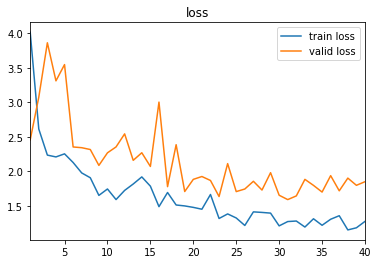

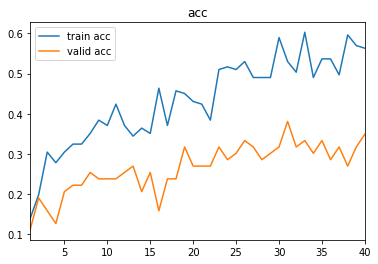

In [46]:
epochs = 40
# freezing the feature part of the pre-trained model 
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Linear(model.classifier.in_features, len(class_names))
model.fc =  nn.Sequential(
         nn.Linear(2208, 1024),
         nn.ReLU(),
         nn.Linear(1024, len(class_names)))

model.apply(weights_init_normal)


criteria = nn.CrossEntropyLoss()    
    
optimizer = optim.Adam(model.parameters(), lr=1e-2)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [7, 20, 25, 30], 0.5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [7, 17, 25, 30], 0.5)

name_model = 'dense161-Adam-lr1e2-MultiStepLR-step7_17_25_30-0_5-drop0-epo40'



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);


model_ft = train_model(model, criteria, optimizer, scheduler, epochs, device, name_model)

In [0]:
modely = models.densenet161(pretrained=False)
modely.classifier = nn.Linear(model_ft.classifier.in_features, len(class_names))
modely.load_state_dict(torch.load(name_model),strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.0.weight', 'fc.0.bias', 'fc.2.weight', 'fc.2.bias'])

In [0]:
print(modely)


Epoch 1/65
----------
Train - Loss: 1.4050 Acc: 0.5232
Valid - Loss: 1.5917 Acc: 0.3810
Validation Acc increased (0.0000 --> 0.3810).  Saving model.

Epoch 2/65
----------
Train - Loss: 1.3943 Acc: 0.4570
Valid - Loss: 1.5537 Acc: 0.4127
Validation Acc increased (0.3810 --> 0.4127).  Saving model.

Epoch 3/65
----------
Train - Loss: 1.3094 Acc: 0.5497
Valid - Loss: 1.4901 Acc: 0.4444
Validation Acc increased (0.4127 --> 0.4444).  Saving model.

Epoch 4/65
----------
Train - Loss: 1.2759 Acc: 0.5695
Valid - Loss: 1.4391 Acc: 0.4444

Epoch 5/65
----------
Train - Loss: 1.3686 Acc: 0.4768
Valid - Loss: 1.4438 Acc: 0.4127

Epoch 6/65
----------
Train - Loss: 1.2965 Acc: 0.5298
Valid - Loss: 1.4360 Acc: 0.4444

Epoch 7/65
----------
Train - Loss: 1.1386 Acc: 0.6225
Valid - Loss: 1.4381 Acc: 0.4286

Epoch 8/65
----------
Train - Loss: 1.2744 Acc: 0.5430
Valid - Loss: 1.4523 Acc: 0.4444

Epoch 9/65
----------
Train - Loss: 1.1922 Acc: 0.6093
Valid - Loss: 1.4123 Acc: 0.4603
Validation Acc in

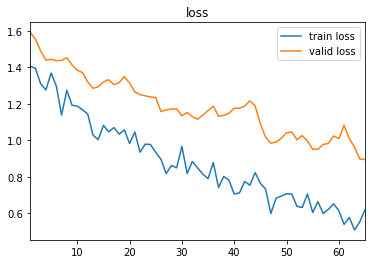

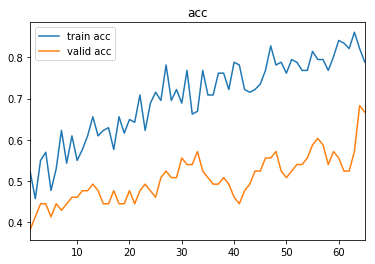

In [0]:
for param in model_ft.parameters():
    param.requires_grad = True

criteria = nn.CrossEntropyLoss()    
    
optimizer = optim.Adam(model_ft.parameters(), lr=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device);

epochs = 50
name_model_unfr = name_model + '-unfreeze-lr1e_5-epo50'
modelxy = train_model(model_ft, criteria, optimizer,None, epochs, device, name_model_unfr)

In [0]:
# save model as a checkpoint file 
def save_model_checkpoint(model, optimizer, criteria, epochs):
  model.to('cpu')
  model.class_to_idx = datasets['train'].class_to_idx
  checkpoint = {'input_size': 224*224*3,
                'output_size': 7,
                'model': model,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'criterion': criteria,
                'epochs': epochs,
                'class_to_idx': model.class_to_idx}

  path = "/content/gdrive/My Drive/facial_expressions/facial_expressions.pth"
  torch.save(checkpoint,path)


# load model function 
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location='cpu')
    model = checkpoint["model"]
    model.load_state_dict(checkpoint['state_dict'])
    return model


In [0]:
save_model_checkpoint(modelxy, optimizer, criteria, epochs)